In [19]:
import os
import torch
from torch import nn
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
from torch.optim import AdamW,Adam
import torch.nn.functional as F
import re
from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta

In [2]:
from transformers import AutoModel,AutoTokenizer,BertModel
from kobert_tokenizer import KoBERTTokenizer

In [3]:
model_path = 'skt/kobert-base-v1' #multilingual

In [4]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = AutoModel.from_pretrained(model_path)
        self.dropout1 = nn.Dropout(dropout)
        self.linear1 = nn.Linear(768, 1024)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(1024,1)
        
    def forward(self, input_id, mask):
        last_hidden_state,_ = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout1(last_hidden_state)
        linear_output = self.linear1(dropout_output)
        dropout_output1 = self.dropout2(linear_output)
        linear_output1 = self.linear2(dropout_output1)
        sigmoid_output = torch.sigmoid(linear_output1)
        return sigmoid_output[:,0,:]

In [5]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
classifier = BertClassifier()
classifier.load_state_dict(torch.load('/home/se/paper/classifier/kobert_base_model/model.pt'))

<All keys matched successfully>

In [6]:
def preprocess(context,null_char='',space_char=' '):
    bracket_removed_context = re.sub(r'\([^)]*\)', null_char, context)
    square_bracket_removed_context = re.sub(r'\[[^]]*\]', null_char, bracket_removed_context)
    punc_removed_context = re.sub(r'[^\w\s]',space_char,square_bracket_removed_context)
    repeated_space_removed_context = re.sub(r'[\n]{2,}','\n',punc_removed_context)
    repeated_space_removed_context.upper()
            
    return repeated_space_removed_context

In [7]:
def predict(contents):
    model_input = tokenizer(preprocess(contents),padding='max_length', max_length = 512, truncation=True,return_tensors="pt")
    mask = model_input['attention_mask']
    input_ids = model_input['input_ids']
    label = classifier(input_ids,mask)
    return round(label.item())

In [8]:
data_path = '/home/se/paper/legacy/data'

In [21]:
class StatDataset(Dataset):
    def __init__(self, match,stat,article,le):
        
        tmp = []
        label = []
        
        for home_pitcher,home_team,away_pitcher,away_team,home_result,date in \
        list(zip(match['home_pitcher'].values,match['home'].values,match['away_pitcher'],match['away'],match['home_result'],match['date'])):
            home_player_stat = stat.loc[(stat['name'] == home_pitcher) & (stat['team'] == home_team)]
            away_player_stat = stat.loc[(stat['name'] == away_pitcher) & (stat['team'] == away_team)]

            if (len(home_player_stat) != 0) and (len(away_player_stat) != 0):
                vector = home_player_stat.values.tolist()[0][2:] + away_player_stat.values.tolist()[0][2:]
                str_date = datetime.strptime(str(date),"%Y%m%d")
                home_article = article.loc[(article['team'] == home_team) & (article['date'] < date)]
                away_article = article.loc[(article['team'] == away_team) & (article['date'] < date)]
                if (len(home_article) != 0) and (len(away_article) != 0):
                    home_sum = 0
                    for index,document in home_article.iterrows():
                        home_sum += document.contents

                    away_sum = 0
                    for index,document in away_article.iterrows():
                        away_sum += document.contents

                    vector.append(home_sum / len(home_article))
                    vector.append(away_sum / len(away_article))

                    tmp.append(vector)
                    label.append(home_result)
        
        transform = le.transform(label)
        self.label = torch.tensor(list(transform),dtype=torch.long)
        self.stat = torch.tensor(tmp)
        
        
    def __len__(self):
        return len(self.stat)

    def __getitem__(self, index):
        return {
                "stat": self.stat[index],
                "label": self.label[index]
                }
        
    def get_num_batches(self, batch_size):
        return len(self) // batch_size

In [22]:
class WindupClassifier(nn.Module):
    def __init__(self, dropout=0.5):
        super(WindupClassifier, self).__init__()
        self.linear1 = nn.Linear(38, 1024)
        self.dropout2 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(1024,3)
        
    def forward(self, input_id):
        linear_output = self.linear1(input_id)
        dropout_output1 = self.dropout2(linear_output)
        linear_output1 = self.linear2(dropout_output1)
        return linear_output1

In [11]:
stat = pd.read_csv(os.path.join(data_path,'average.csv'))
match = pd.read_csv(os.path.join(data_path,'match_day.csv'))
article = pd.read_csv(os.path.join(data_path,'article.csv'))
article['contents'] = article['contents'].apply(predict)

In [23]:
le = LabelEncoder()
_=le.fit(['승','패','무승부'])

In [24]:
train_match,valid_match = train_test_split(match,shuffle=True,random_state=56)

In [25]:
train_dataset = StatDataset(train_match,stat,article,le)

In [26]:
valid_dataset = StatDataset(valid_match,stat,article,le)

In [27]:
print(len(train_dataset),len(valid_dataset))

465 151


In [28]:
batch_size = 16
epochs = 100
device='cuda'

In [29]:
le.classes_

array(['무승부', '승', '패'], dtype='<U3')

In [30]:
train_class = pd.DataFrame(train_dataset.label)
train_class_counts = [len(train_class.loc[train_class[0] == 0]) , len(train_class.loc[train_class[0] == 1])  , len(train_class.loc[train_class[0] == 2])]
train_num_samples = sum(train_class_counts)
train_labels = list(train_class.values.reshape(-1))

train_class_weights = [train_num_samples / train_class_counts[i] for i in range(len(train_class_counts))] 

# 해당 데이터의 label에 해당되는 가중치
train_weights = [train_class_weights[train_labels[i]] for i in range(int(train_num_samples))] #해당 레이블마다의 가중치 비율
train_sampler = WeightedRandomSampler(torch.DoubleTensor(train_weights), int(train_num_samples))

In [31]:
valid_class = pd.DataFrame(valid_dataset.label)
valid_class_counts = [len(valid_class.loc[train_class[0] == 0]) , len(valid_class.loc[train_class[0] == 1])  , len(valid_class.loc[train_class[0] == 2])]
valid_num_samples = sum(valid_class_counts)
valid_labels = list(valid_class.values.reshape(-1))

valid_class_weights = [valid_num_samples / valid_class_counts[i] for i in range(len(valid_class_counts))] 

# 해당 데이터의 label에 해당되는 가중치
valid_weights = [valid_class_weights[valid_labels[i]] for i in range(int(valid_num_samples))] #해당 레이블마다의 가중치 비율
valid_sampler = WeightedRandomSampler(torch.DoubleTensor(valid_weights), int(valid_num_samples))

In [32]:
classifier = WindupClassifier()
classifier.cuda()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3)

In [33]:
criterion = nn.CrossEntropyLoss()
_=criterion.cuda()

In [34]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,sampler = train_sampler)
val_dataloader = DataLoader(valid_dataset, batch_size=batch_size,shuffle=False,sampler = valid_sampler)

In [35]:
train_loss = []
train_acc = []

valid_loss = []
valid_acc = []

In [36]:
classifier.zero_grad()
for epoch in tqdm(range(epochs),total=epochs):

    total_acc_train = 0
    total_loss_train = 0
    classifier.train()
    for i,batch in enumerate(train_dataloader):

        train_label = batch['label'].to(device)
        train_stat = batch['stat'].to(device)
        
        output = classifier(train_stat)
        output = output.squeeze(1)
        batch_loss = criterion(output.float(), train_label)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        total_loss_train += batch_loss.item()
        
        correct_prediction = torch.argmax(F.softmax(output, dim=1), 1) == train_label
        acc = correct_prediction.float().mean()
#         acc = (output.round() == train_label).sum().item()
        total_acc_train += acc.item()
        
    train_loss.append(total_loss_train/len(train_dataloader))
    train_acc.append(total_acc_train/len(train_dataloader))
            
    total_acc_val = 0
    total_loss_val = 0
    
    with  torch.no_grad():
        classifier.eval()
        for i,batch in enumerate(val_dataloader):
            
            val_label = batch['label'].to(device)
            val_stat = batch['stat'].to(device)

            output = classifier(val_stat)
            output = output.squeeze(1)
            batch_loss = criterion(output.float(), val_label)
            
            total_loss_val += batch_loss.item()
            correct_prediction = torch.argmax(F.softmax(output, dim=1), 1) == val_label
            acc = correct_prediction.float().mean()
#             acc = (output.round() == val_label).sum().item()
            
            total_acc_val += acc.item()

        valid_loss.append(total_loss_val/ len(val_dataloader))
        valid_acc.append(total_acc_val/ len(val_dataloader))
#         torch.save(classifier.state_dict(), './model{}.pt'.format(epoch))
 
        print(
                f'Epochs: {epoch + 1} | Train Loss: {total_loss_train / len(train_dataloader): .3f} \
                | Train Accuracy: {total_acc_train / len(train_dataloader): .3f} \
                | Val Loss: {total_loss_val / len(val_dataloader): .3f} \
                | Val Accuracy: {total_acc_val / len(val_dataloader): .3f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 1 | Train Loss:  1.338                 | Train Accuracy:  0.350                 | Val Loss:  0.967                 | Val Accuracy:  0.599
Epochs: 2 | Train Loss:  1.235                 | Train Accuracy:  0.425                 | Val Loss:  1.094                 | Val Accuracy:  0.383
Epochs: 3 | Train Loss:  1.394                 | Train Accuracy:  0.371                 | Val Loss:  0.855                 | Val Accuracy:  0.626
Epochs: 4 | Train Loss:  1.104                 | Train Accuracy:  0.481                 | Val Loss:  1.017                 | Val Accuracy:  0.570
Epochs: 5 | Train Loss:  1.184                 | Train Accuracy:  0.446                 | Val Loss:  1.027                 | Val Accuracy:  0.510
Epochs: 6 | Train Loss:  1.030                 | Train Accuracy:  0.508                 | Val Loss:  0.924                 | Val Accuracy:  0.551
Epochs: 7 | Train Loss:  1.095                 | Train Accuracy:  0.515                 | Val Loss:  1.358                 |

In [37]:
from matplotlib import pyplot as plt

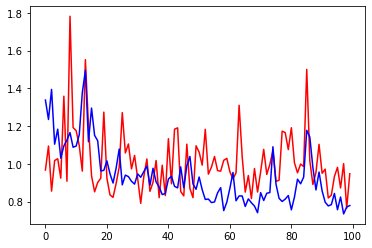

In [38]:
plt.plot(valid_loss,color='red',label = 'valid')
plt.plot(train_loss,color='blue',label = 'train')
plt.show()

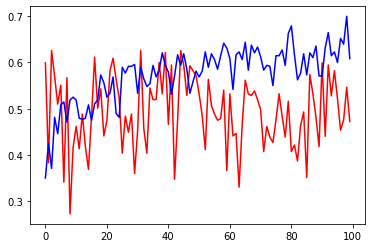

In [39]:
plt.plot(valid_acc,color='red',label = 'valid')
plt.plot(train_acc,color='blue',label = 'train')
plt.show()

In [40]:
max(valid_acc)

0.6258928596973419